In [11]:
!pip install ucimlrepo
!pip install tensorflow
!pip install scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

In [12]:
rice_cammeo_osmancik = fetch_ucirepo(id=545)

X = rice_cammeo_osmancik.data.features
y = rice_cammeo_osmancik.data.targets

print("Информация о датасете Rice:")
print(f"Размерность признаков (X): {X.shape}")
print(f"Размерность целевой переменной (y): {y.shape}")

print("\nНазвания признаков:")
print(X.columns.tolist())

print("\nНазвания целевых переменных:")
print(y.columns.tolist())

print("\nУникальные значения в Class:")
print(y['Class'].value_counts().sort_index())

print("\nПервые 5 строк признаков:")
print(X.head())

print("\nПервые 5 строк целевой переменной:")
print(y.head())

Информация о датасете Rice:
Размерность признаков (X): (3810, 7)
Размерность целевой переменной (y): (3810, 1)

Названия признаков:
['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']

Названия целевых переменных:
['Class']

Уникальные значения в Class:
Class
Cammeo      1630
Osmancik    2180
Name: count, dtype: int64

Первые 5 строк признаков:
    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent  
0        15617  0.572896  
1        15072  0.615436  
2        14954  0.693259  
3        13368  0.640669  
4       

Пропущенные значения в X: 0
Пропущенные значения в y: 0

Распределение классов в целевой переменной:
0    1630
1    2180
Name: count, dtype: int64

Соответствие классов:
Класс 0 (Cammeo): 1630 примеров
Класс 1 (Osmancik): 2180 примеров


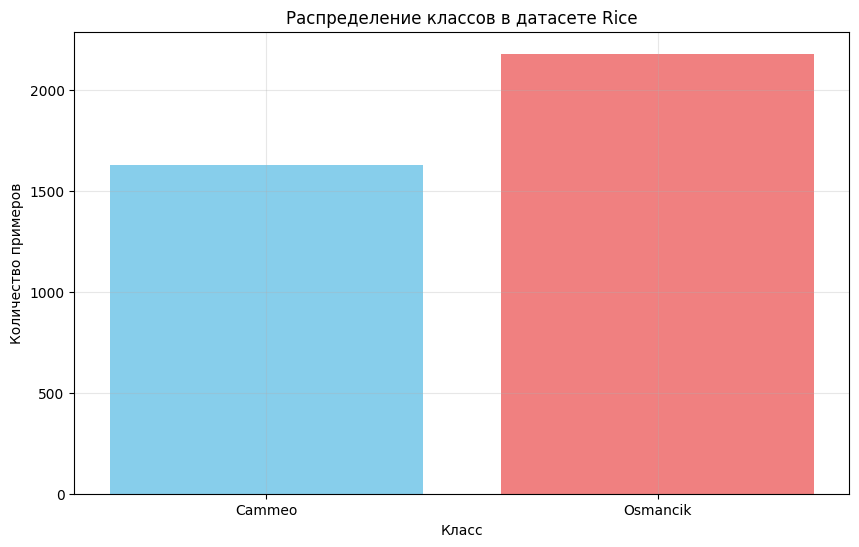


Размер train выборки: (3048, 7)
Размер test выборки: (762, 7)
Количество классов: 2
Количество признаков: 7


In [13]:
print(f"Пропущенные значения в X: {X.isnull().sum().sum()}")
print(f"Пропущенные значения в y: {y.isnull().sum().sum()}")

if X.isnull().sum().sum() > 0:
    print("Заполняем пропущенные значения...")
    X = X.fillna(X.mean())

y_target = y['Class'].map({'Cammeo': 0, 'Osmancik': 1}).values

print(f"\nРаспределение классов в целевой переменной:")
class_distribution = pd.Series(y_target).value_counts().sort_index()
print(class_distribution)

class_names = {
    0: 'Cammeo',
    1: 'Osmancik'
}

print("\nСоответствие классов:")
for class_id, class_name in class_names.items():
    count = class_distribution.get(class_id, 0)
    print(f"Класс {class_id} ({class_name}): {count} примеров")

plt.figure(figsize=(10, 6))
plt.bar(class_names.values(), class_distribution.values, color=['skyblue', 'lightcoral'])
plt.title('Распределение классов в датасете Rice')
plt.ylabel('Количество примеров')
plt.xlabel('Класс')
plt.grid(True, alpha=0.3)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, random_state=42, stratify=y_target
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмер train выборки: {X_train_scaled.shape}")
print(f"Размер test выборки: {X_test_scaled.shape}")
print(f"Количество классов: {len(np.unique(y_target))}")
print(f"Количество признаков: {X_train_scaled.shape[1]}")

In [14]:
def create_base_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_target))

base_model = create_base_model(input_dim, num_classes)
base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура базовой модели:")
base_model.summary()

history_base = base_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_base, test_accuracy_base = base_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nБазовая модель - Test Accuracy: {test_accuracy_base:.4f}")

БАЗОВАЯ МОДЕЛЬ (без предобучения)
Архитектура базовой модели:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,426 (44.63 KB)

 Trainable params: 11,426 (44.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8704 - loss: 0.3792 - val_accuracy: 0.9164 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9357 - loss: 0.1795 - val_accuracy: 0.9164 - val_loss: 0.2269 - learning_rate: 0.0010
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9279 - loss: 0.1835 - val_accuracy: 0.9164 - val_loss: 0.2291 - learning_rate: 0.0010
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9261 - loss: 0.1798 - val_accuracy: 0.9148 - val_loss: 0.2296 - learning_rate: 0.0010
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9289 - loss: 0.1956 - val_accuracy: 0.9131 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9347 - loss: 0.1788 - val_accuracy: 0.9180 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9336 - loss: 0.1745 - val

In [15]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.01, momentum=0.9):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

        self.W_inc = np.zeros((n_visible, n_hidden))
        self.v_bias_inc = np.zeros(n_visible)
        self.h_bias_inc = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.W) + self.h_bias
        p_hidden = self.sigmoid(activation)
        return p_hidden, np.random.binomial(1, p_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.W.T) + self.v_bias
        p_visible = self.sigmoid(activation)
        return p_visible, np.random.binomial(1, p_visible)

    def contrastive_divergence(self, input_data, k=1):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(input_data)

        hidden_states = pos_hidden_states
        for _ in range(k):
            neg_visible_probs, neg_visible_states = self.sample_visible(hidden_states)
            neg_hidden_probs, neg_hidden_states = self.sample_hidden(neg_visible_states)
            hidden_states = neg_hidden_states

        positive_associations = np.dot(input_data.T, pos_hidden_probs)
        negative_associations = np.dot(neg_visible_states.T, neg_hidden_probs)

        self.W_inc = self.momentum * self.W_inc + \
                    self.learning_rate * ((positive_associations - negative_associations) / len(input_data))
        self.v_bias_inc = self.momentum * self.v_bias_inc + \
                         self.learning_rate * np.mean(input_data - neg_visible_states, axis=0)
        self.h_bias_inc = self.momentum * self.h_bias_inc + \
                         self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

        self.W += self.W_inc
        self.v_bias += self.v_bias_inc
        self.h_bias += self.h_bias_inc

        reconstruction_error = np.mean((input_data - neg_visible_probs) ** 2)
        return reconstruction_error

    def transform(self, data):
        hidden_probs, _ = self.sample_hidden(data)
        return hidden_probs

    def get_weights(self):
        return [self.W, self.h_bias]

1. Обучение первого RBM слоя:
   Epoch 0, Reconstruction Error: 0.0191
   Epoch 20, Reconstruction Error: 0.0134
   Epoch 40, Reconstruction Error: 0.0128
   Epoch 60, Reconstruction Error: 0.0128
   Epoch 80, Reconstruction Error: 0.0127
2. Обучение второго RBM слоя:
   Epoch 0, Reconstruction Error: 0.0002
   Epoch 20, Reconstruction Error: 0.0001
   Epoch 40, Reconstruction Error: 0.0001
   Epoch 60, Reconstruction Error: 0.0001
   Epoch 80, Reconstruction Error: 0.0001
3. Обучение третьего RBM слоя:
   Epoch 0, Reconstruction Error: 0.0002
   Epoch 20, Reconstruction Error: 0.0001
   Epoch 40, Reconstruction Error: 0.0000
   Epoch 60, Reconstruction Error: 0.0000
   Epoch 80, Reconstruction Error: 0.0000


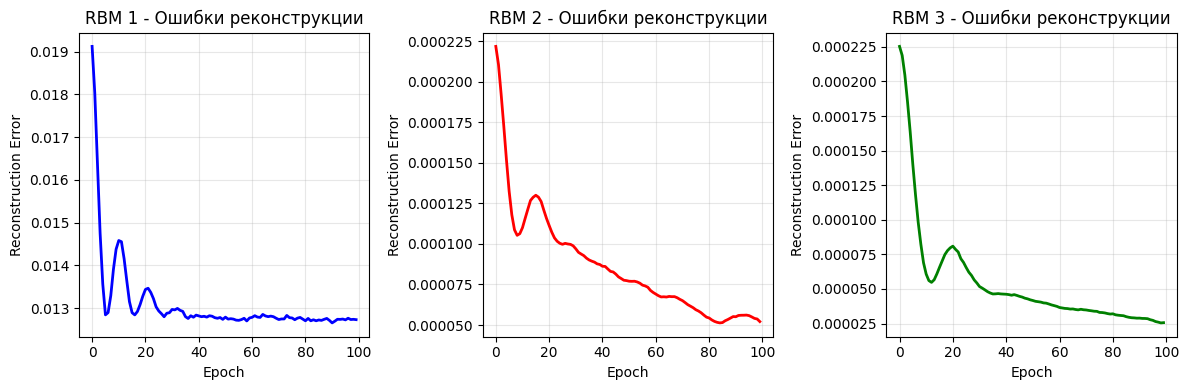

In [16]:
X_min = X_train_scaled.min()
X_max = X_train_scaled.max()
X_train_rbm = (X_train_scaled - X_min) / (X_max - X_min)
X_test_rbm = (X_test_scaled - X_min) / (X_max - X_min)

pretrained_weights_rbm = []

print("1. Обучение первого RBM слоя:")
rbm1 = RBM(n_visible=input_dim, n_hidden=128, learning_rate=0.01, momentum=0.9)

rbm1_errors = []
for epoch in range(100):
    error = rbm1.contrastive_divergence(X_train_rbm, k=1)
    rbm1_errors.append(error)
    if epoch % 20 == 0:
        print(f"   Epoch {epoch}, Reconstruction Error: {error:.4f}")

pretrained_weights_rbm.append(rbm1.get_weights())
hidden1_output = rbm1.transform(X_train_rbm)

print("2. Обучение второго RBM слоя:")
rbm2 = RBM(n_visible=128, n_hidden=64, learning_rate=0.01, momentum=0.9)

rbm2_errors = []
for epoch in range(100):
    error = rbm2.contrastive_divergence(hidden1_output, k=1)
    rbm2_errors.append(error)
    if epoch % 20 == 0:
        print(f"   Epoch {epoch}, Reconstruction Error: {error:.4f}")

pretrained_weights_rbm.append(rbm2.get_weights())
hidden2_output = rbm2.transform(hidden1_output)

print("3. Обучение третьего RBM слоя:")
rbm3 = RBM(n_visible=64, n_hidden=32, learning_rate=0.01, momentum=0.9)

rbm3_errors = []
for epoch in range(100):
    error = rbm3.contrastive_divergence(hidden2_output, k=1)
    rbm3_errors.append(error)
    if epoch % 20 == 0:
        print(f"   Epoch {epoch}, Reconstruction Error: {error:.4f}")

pretrained_weights_rbm.append(rbm3.get_weights())

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(rbm1_errors, color='blue', linewidth=2)
plt.title('RBM 1 - Ошибки реконструкции')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(rbm2_errors, color='red', linewidth=2)
plt.title('RBM 2 - Ошибки реконструкции')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(rbm3_errors, color='green', linewidth=2)
plt.title('RBM 3 - Ошибки реконструкции')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
pretrained_model_rbm = models.Sequential()
pretrained_model_rbm.add(layers.Dense(128, activation='sigmoid', input_shape=(input_dim,), name='pretrained_layer1'))
pretrained_model_rbm.add(layers.Dropout(0.3))
pretrained_model_rbm.add(layers.Dense(64, activation='sigmoid', name='pretrained_layer2'))
pretrained_model_rbm.add(layers.Dropout(0.3))
pretrained_model_rbm.add(layers.Dense(32, activation='sigmoid', name='pretrained_layer3'))
pretrained_model_rbm.add(layers.Dropout(0.2))
pretrained_model_rbm.add(layers.Dense(num_classes, activation='softmax', name='output_layer'))
$
pretrained_model_rbm.layers[0].set_weights([pretrained_weights_rbm[0][0], pretrained_weights_rbm[0][1]])
pretrained_model_rbm.layers[2].set_weights([pretrained_weights_rbm[1][0], pretrained_weights_rbm[1][1]])
pretrained_model_rbm.layers[4].set_weights([pretrained_weights_rbm[2][0], pretrained_weights_rbm[2][1]])

pretrained_model_rbm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура модели с RBM предобучением:")
pretrained_model_rbm.summary()

Установка предобученных весов RBM...
Архитектура модели с RBM предобучением:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_layer1 (Dense)       │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer2 (Dense)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer3 (Dense)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,426 (44.63 KB)

 Trainable params: 11,426 (44.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_pretrained_rbm = pretrained_model_rbm.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_rbm, test_accuracy_rbm = pretrained_model_rbm.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nМодель с RBM предобучением - Test Accuracy: {test_accuracy_rbm:.4f}")

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5378 - loss: 0.7231 - val_accuracy: 0.5803 - val_loss: 0.6769 - learning_rate: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5554 - loss: 0.7003 - val_accuracy: 0.7869 - val_loss: 0.5105 - learning_rate: 0.0010
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8385 - loss: 0.4111 - val_accuracy: 0.9131 - val_loss: 0.2359 - learning_rate: 0.0010
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9209 - loss: 0.2183 - val_accuracy: 0.9148 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9199 - loss: 0.2216 - val_accuracy: 0.9164 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9306 - loss: 0.1945 - val_accuracy: 0.9164 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9280 - loss: 0.2006 - va

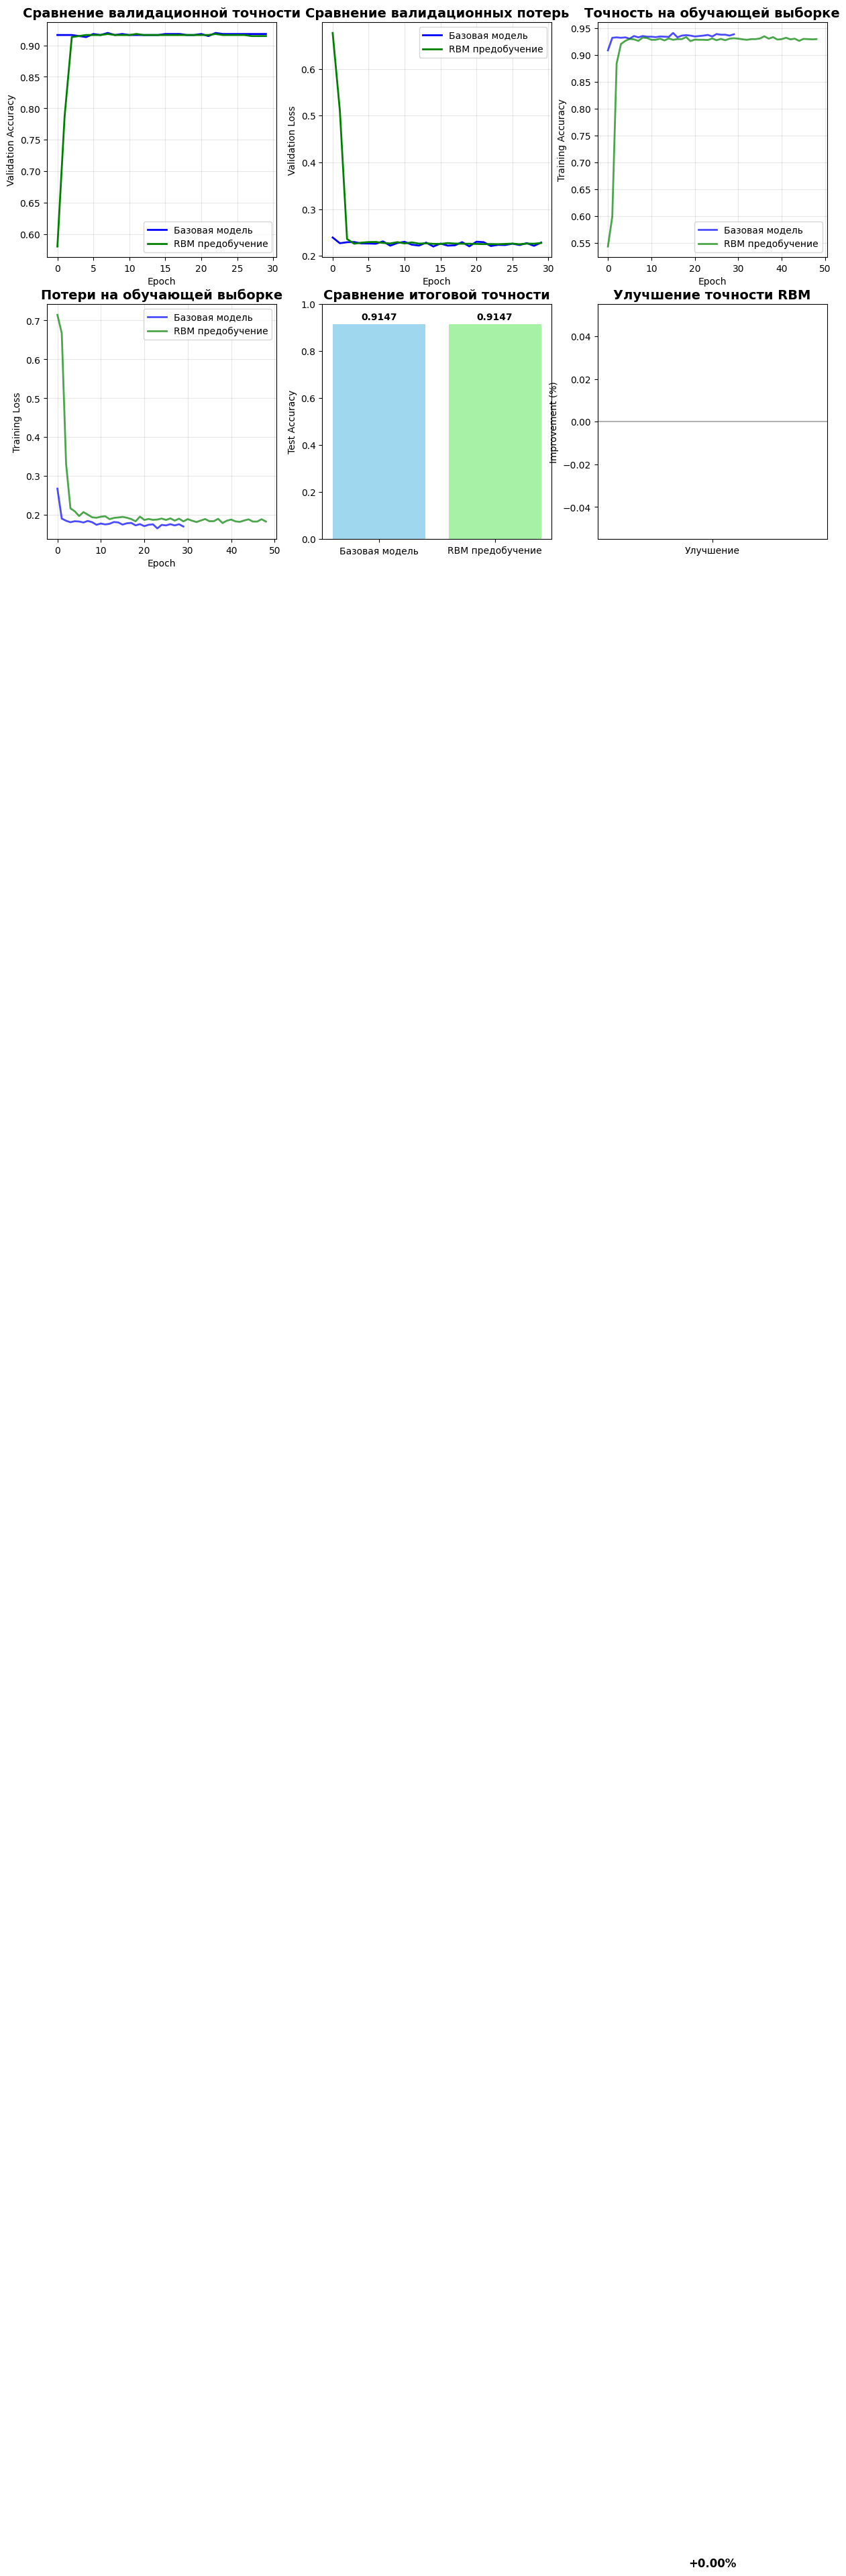

In [19]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
min_epochs = min(len(history_base.history['val_accuracy']),
                 len(history_pretrained_rbm.history['val_accuracy']))
epochs_range = range(min_epochs)

plt.plot(epochs_range, history_base.history['val_accuracy'][:min_epochs],
         label='Базовая модель', linewidth=2, color='blue')
plt.plot(epochs_range, history_pretrained_rbm.history['val_accuracy'][:min_epochs],
         label='RBM предобучение', linewidth=2, color='green')
plt.title('Сравнение валидационной точности', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(epochs_range, history_base.history['val_loss'][:min_epochs],
         label='Базовая модель', linewidth=2, color='blue')
plt.plot(epochs_range, history_pretrained_rbm.history['val_loss'][:min_epochs],
         label='RBM предобучение', linewidth=2, color='green')
plt.title('Сравнение валидационных потерь', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.plot(history_base.history['accuracy'], label='Базовая модель', linewidth=2, color='blue', alpha=0.7)
plt.plot(history_pretrained_rbm.history['accuracy'], label='RBM предобучение', linewidth=2, color='green', alpha=0.7)
plt.title('Точность на обучающей выборке', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
plt.plot(history_base.history['loss'], label='Базовая модель', linewidth=2, color='blue', alpha=0.7)
plt.plot(history_pretrained_rbm.history['loss'], label='RBM предобучение', linewidth=2, color='green', alpha=0.7)
plt.title('Потери на обучающей выборке', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
models_names = ['Базовая модель', 'RBM предобучение']
accuracies = [test_accuracy_base, test_accuracy_rbm]
colors = ['skyblue', 'lightgreen']
bars = plt.bar(models_names, accuracies, color=colors, alpha=0.8)
plt.title('Сравнение итоговой точности', fontsize=14, fontweight='bold')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.subplot(2, 3, 6)
improvement = (test_accuracy_rbm - test_accuracy_base) * 100
colors_imp = ['red' if improvement < 0 else 'green']
plt.bar(['Улучшение'], [improvement], color=colors_imp, alpha=0.8)
plt.title('Улучшение точности RBM', fontsize=14, fontweight='bold')
plt.ylabel('Improvement (%)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.text(0, improvement + (1 if improvement > 0 else -1),
         f'{improvement:+.2f}%', ha='center', va='bottom' if improvement > 0 else 'top',
         fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()